In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Reading the file

In [39]:
errand_df = pd.read_parquet('Data/errands.parquet')
errand_df.head()


,order_number,errand_id,created,errand_category,errand_type,errand_action,errand_channel,is_test_errand
0,24770FC,52497975,2023-12-31 08:59:49,6: Payment questions,2: Payment not conf - CC,1: Info provided,1: Phone In,0
1,2479LIP,52502839,2023-12-31 11:36:31,6: Payment questions,3: Payment not conf - bank,1: Info provided,1: Phone In,0
2,247BO81,52520705,2024-01-01 00:02:32,6: Payment questions,6: No order but charged / charged twice / rese...,1: Info provided,19: Chat,0
3,247BZ9A,52520962,2024-01-01 00:23:39,9: Other services / products,3: Other airline services,7: Other,19: Chat,0
4,247BZDY,52521010,2024-01-01 00:28:26,5: Document & travel info,1: Have no document,6: Other,19: Chat,1


In [ ]:
errand_df.columns 

Index(['order_number', 'errand_id', 'created', 'errand_category',
       'errand_type', 'errand_action', 'errand_channel', 'is_test_errand'],
      dtype='object')

It seems there are errands that have been run as a test. There is no documentation on them. Relying on this understanding, drop the rows that are test errands

In [40]:
errand_df = errand_df[errand_df['is_test_errand'] != 1]


In [41]:
X = errand_df['errand_category'].unique().tolist()
print(X)

['6: Payment questions', '9: Other services / products', '2: Cancellation / refund', '5: Document & travel info', '1: Rebooking', '43: No response', '7: Baggage', '4: Change of name & passenger info', '8: Seating', '18: Schedule change', '41: Call disconnected', '3: Claim wrong itinerary/dupe', '13: Language problem', '11: Site support', '14: FL Fraud errands process', '25: Other Booking.com products', '20: Ancillary team', '46: No information provided', '10: Force Majeure', '24: Accommodation ', '26: Booking.com phase 1 - No order in Edvin', '27: Trustpilot', '31: P&F Fraud', '54: Claim form sent', '34: Backend BOM', '32: P&F Chargeback', '30: Supplier Call', '23: Legal and Authority Claims Team', '42: Customer feedback', '16: Backend UPA', '44: Payouts & Accounting', '22: Backend ATH', '29: Leaders', '36: ETG Escalation', '50: Consumer Claims Team', '40: Backend BOM TKT', '53: Retail Loss', '55: Manual Booking', '49: FL/SC OUT Support', '15: CT UPA', '45: FL Coordinators', '52: Priva

In [ ]:
errand_df['created'] = pd.to_datetime(errand_df['created'])
errand_df['YearMonth'] = errand_df['created'].dt.to_period('M')
price_index = errand_df.columns.get_loc('created')
errand_df.insert(price_index + 1, 'YearMonth', errand_df.pop('YearMonth'))
# errand_df.drop('created', axis=1)






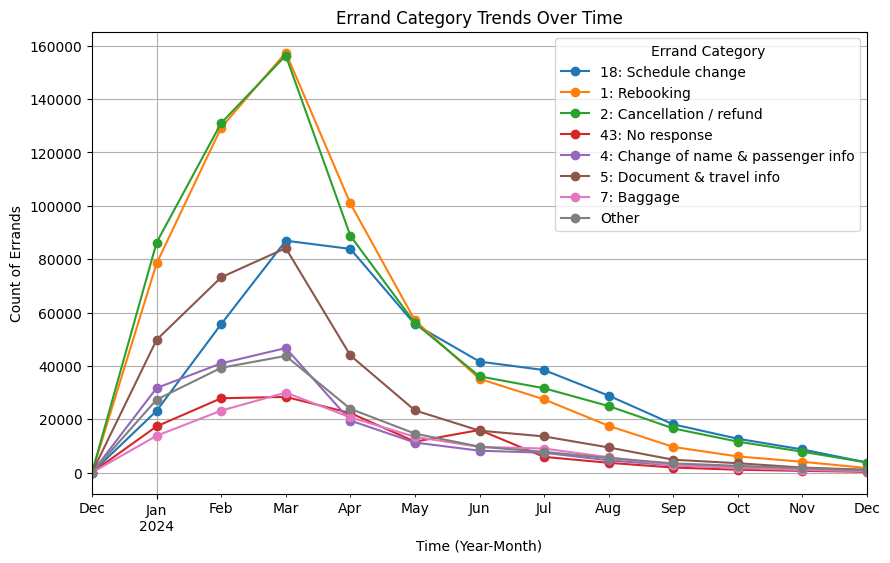

In [51]:
category_counts = errand_df['errand_category'].value_counts()
total_errands = category_counts.sum()

threshold = 0.02 * total_errands
low_frequency_categories = category_counts[category_counts < threshold].index


errand_df['errand_category'] = errand_df['errand_category'].replace(low_frequency_categories, 'Other')
category_trends = errand_df.groupby(['YearMonth', 'errand_category']).size().reset_index(name='Count')

pivot_data = category_trends.pivot(index='YearMonth', columns='errand_category', values='Count').fillna(0)



pivot_data.plot(kind='line', figsize=(10, 6), marker='o')
plt.title('Errand Category Trends Over Time')
plt.xlabel('Time (Year-Month)')
plt.ylabel('Count of Errands')
plt.legend(title='Errand Category', loc= 'upper right')
plt.grid(True)

plt.show()

The most common errand type within each errand category

In [54]:
type_counts = errand_df.groupby(['errand_category', 'errand_type']).size().reset_index(name='Count')

most_common_types = type_counts.loc[type_counts.groupby('errand_category')['Count'].idxmax()]
print(most_common_types)


                        errand_category                  errand_type   Count
3                   18: Schedule change     2: We have inf. about SC  227403
12                         1: Rebooking        1: No Flexible Ticket  459075
27             2: Cancellation / refund      1: Ask about cxnl rules  450383
38                      43: No response      1. Customer not reached  136635
39   4: Change of name & passenger info           1: Name correction   97800
52            5: Document & travel info       5: Itinerary questions  107714
57                           7: Baggage       1: Baggage information  117635
151                               Other  2: Seating light / seat map   37334


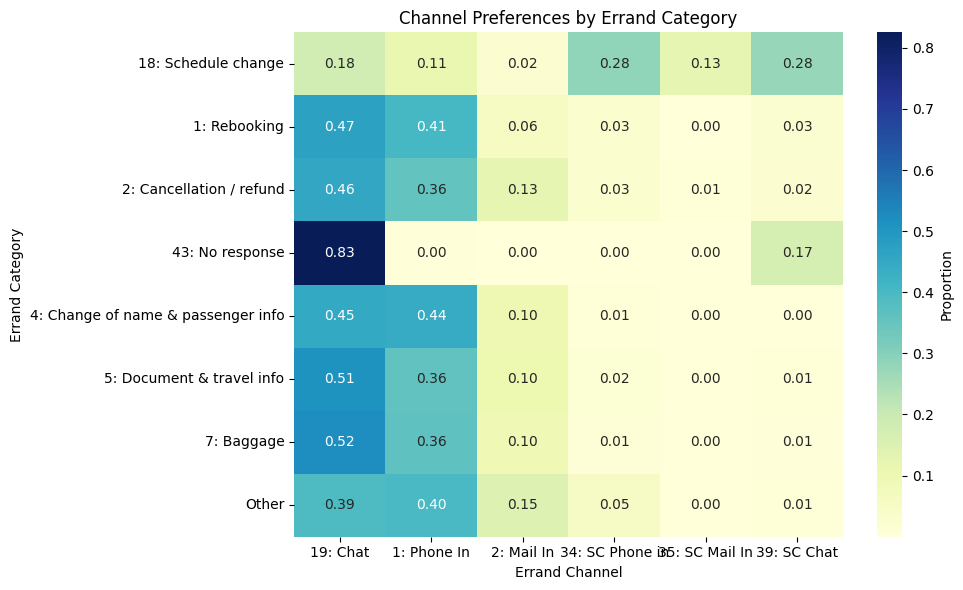

In [ ]:

channel_prefs = errand_df.groupby(['errand_category', 'errand_channel']).size().reset_index(name='Count')

pivot_data = channel_prefs.pivot(index='errand_category', columns='errand_channel', values='Count').fillna(0)

pivot_normalized = pivot_data.div(pivot_data.sum(axis=1), axis=0)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_normalized, annot=True, cmap="YlGnBu", fmt=".2f", cbar_kws={'label': 'Proportion'})
plt.title('Channel Preferences by Errand Category')
plt.xlabel('Errand Channel')
plt.ylabel('Errand Category')
plt.tight_layout()
plt.show()


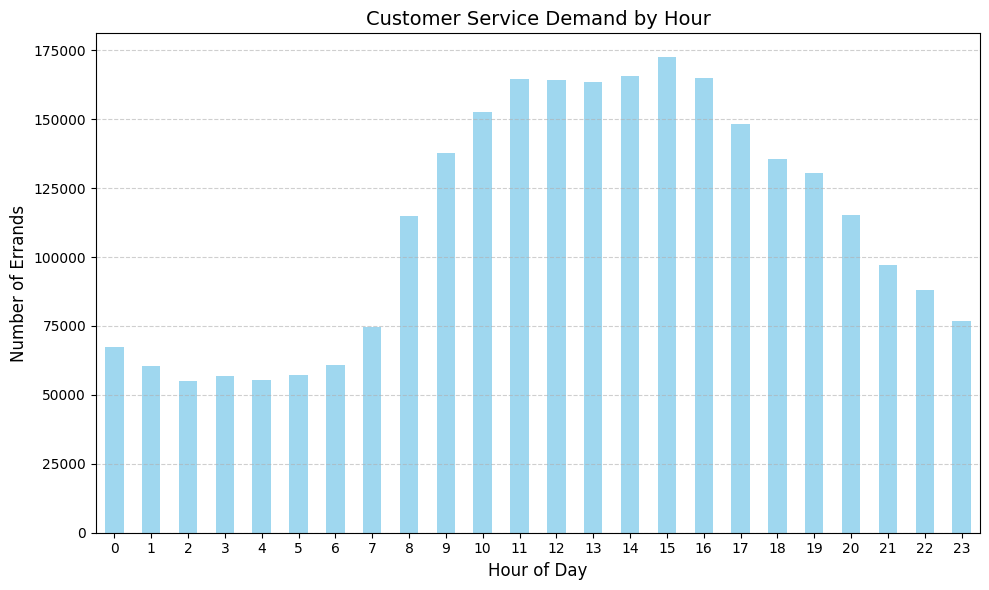

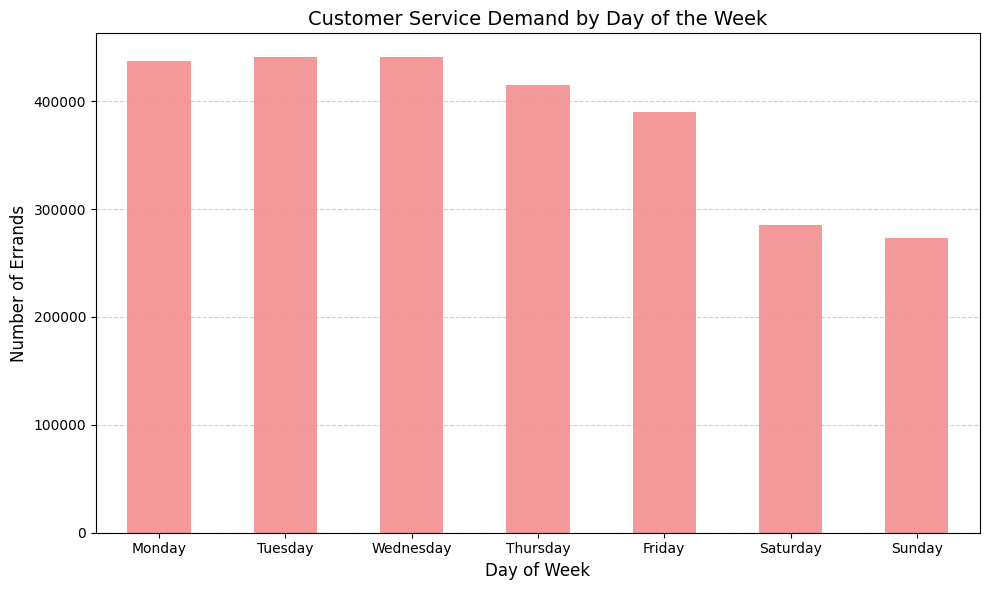

In [ ]:
errand_df['Hour'] = errand_df['created'].dt.hour
errand_df['Day_of_Week'] = errand_df['created'].dt.day_name()
errand_df['Month'] = errand_df['created'].dt.month
errand_df['Year'] = errand_df['created'].dt.year

hourly_trend = errand_df.groupby('Hour').size()

plt.figure(figsize=(10, 6))
hourly_trend.plot(kind='bar', color='skyblue', alpha=0.8)
plt.title('Customer Service Demand by Hour', fontsize=14)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Number of Errands', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

weekday_trend = errand_df.groupby('Day_of_Week').size()


plt.figure(figsize=(10, 6))
weekday_trend.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).plot(kind='bar', color='lightcoral', alpha=0.8)
plt.title('Customer Service Demand by Day of the Week', fontsize=14)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Number of Errands', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
action_counts = errand_df['errand_action'].value_counts()

top_actions = action_counts.head(10)
print(top_actions)

errand_action
3: No change made                   361853
1: Info provided                    190386
3: Not cxnl reservation             186354
1: Chat disconnected                136635
1: Cnxl reservation                 120750
1: SC - Information provided        106126
5: Referred to airline              100621
1: Interaction transferred to SC     82701
7: Referred to airline               78297
2: Infd refund pending               75990
Name: count, dtype: int64


In [ ]:
most_frequent_action = top_actions.index[0] 
filtered_df = errand_df[errand_df['errand_action'] == most_frequent_action]

distribution = filtered_df['errand_category'].value_counts()
print(distribution)

errand_category
1: Rebooking    361853
Name: count, dtype: int64


In [68]:
action_counts = errand_df.groupby(["errand_category", "errand_action"]).size().reset_index(name="Count")
most_frequent_action = action_counts.loc[action_counts.groupby("errand_category")["Count"].idxmax()]


print("Most Frequent Errand Action by Category:")
print(most_frequent_action)


Most Frequent Errand Action by Category:
                        errand_category                 errand_action   Count
22                  18: Schedule change  1: SC - Information provided  106126
70                         1: Rebooking             3: No change made  361853
121            2: Cancellation / refund       3: Not cxnl reservation  186354
146                     43: No response          1: Chat disconnected  136635
155  4: Change of name & passenger info                2: Apis / Docs   34375
182           5: Document & travel info              1: Info provided  171439
213                          7: Baggage             1: Infd allowance   49099
299                               Other              1: Info provided   18862
